In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *

from train_config import *

2024-04-13 12:49:16.934708: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 12:49:16.967893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open("inference/train_config.json", "r") as f:
    CONFIG = json.load(f)
    

In [3]:
CONFIG

{'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': [224, 224],
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 32,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'EPOCHS': 20,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EMBED_DIM': 512,
 'FF_DIM': 256,
 'ENC_HEADS': 2,
 'DEC_HEADS': 2,
 'LR': 0.001,
 'ARTIFACT_DIR': 'artifacts'}

In [6]:
model = load_trained_model_weights("inference/model_weights.h5", CONFIG)

In [7]:
model.summary()

Model: "image_captioning_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block_  multiple                  2760192   
 1 (TransformerEncoderBlock                                      
 )                                                               
                                                                 
 transformer_decoder_block_  multiple                  14733840  
 1 (TransformerDecoderBlock                                      
 )                                                               
                                                                 
Total params: 24069275 (91.82 MB)
Trainable params: 17494032 (66.73 MB)
Non-trainable params: 6575243 (25.08 MB)
_____________________________________________________________

In [8]:
tokenizer = load_tokenizer("inference/tokenizer.keras")

In [9]:
caption_model = model

In [11]:
val_captionings_df = pd.read_csv("splits/val_captions.csv")

vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = val_captionings_df.iloc[1: 100]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, IMAGE_SIZE)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(img / 255.0)
    

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("end", "").strip()
    print("Predicted Caption: ", decoded_caption)

    plt.show()

2024-04-13 12:53:40.803545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-13 12:53:42.042359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Predicted Caption:  a man is performing a jump on a bandanna


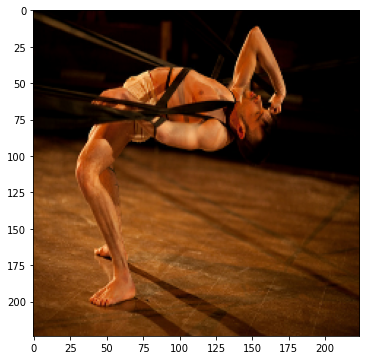

Predicted Caption:  a man in a yellow shirt and blue jeans is pushing a cart


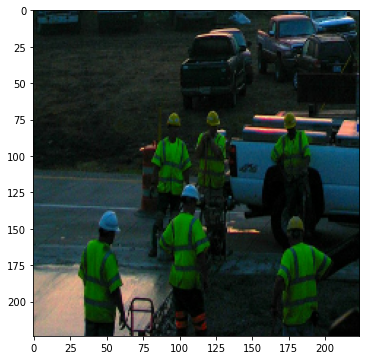

Predicted Caption:  a woman in a white shirt is talking to a microphone


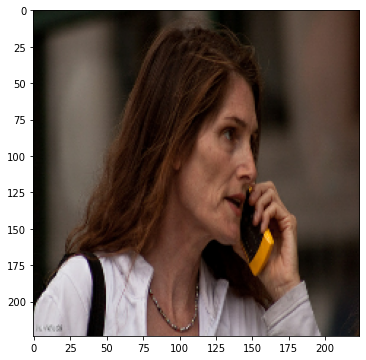

Predicted Caption:  a soccer player in a red uniform is running on a field


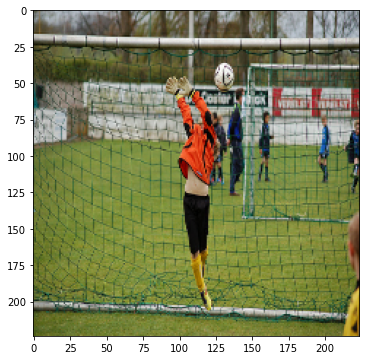

Predicted Caption:  a man in a red shirt is standing in front of a red wall


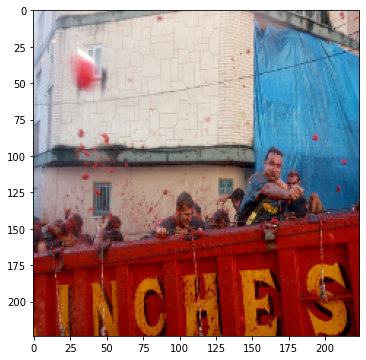

Predicted Caption:  a woman is sweeping the floor


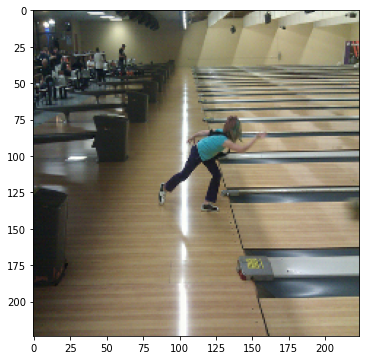

Predicted Caption:  a man and a woman are walking down a sidewalk


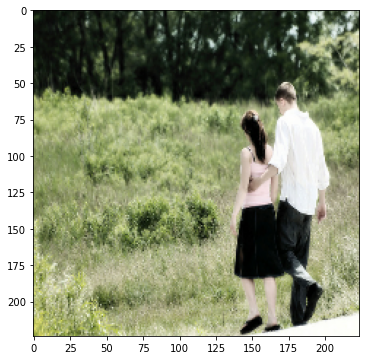

Predicted Caption:  a brown and white dog runs through the woods


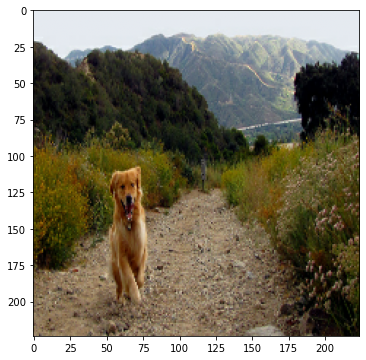

Predicted Caption:  a man is climbing a pole with a white shirt and blue jeans


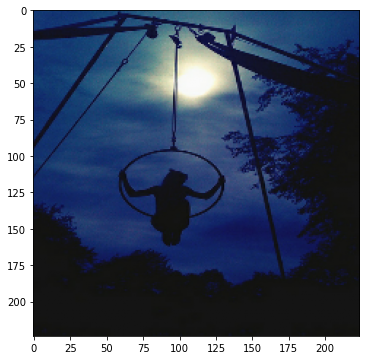

Predicted Caption:  a group of people are playing a game


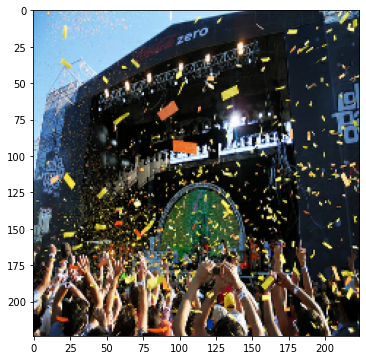

Predicted Caption:  a man playing a guitar and playing a guitar


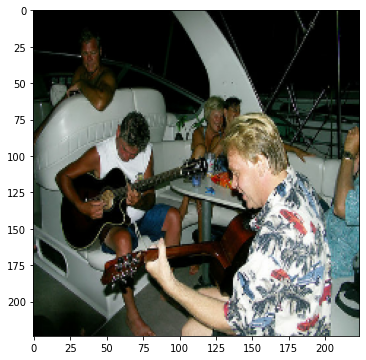

Predicted Caption:  a young boy in a red shirt and jeans is walking down the street


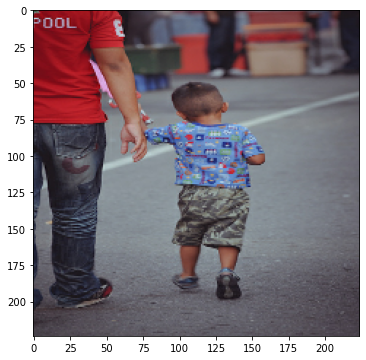

In [12]:
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()